In [1]:
import eland as ed
import numpy as np
import matplotlib.pyplot as plt
import os

from elasticsearch import Elasticsearch
from dotenv import load_dotenv

os.chdir("..")
load_dotenv()

True

In [2]:
es_url = os.environ.get('ELASTICSEARCH_URL')
es_api_key = os.environ.get('ELASTICSEARCH_API_KEY')
es = Elasticsearch(hosts=[f"{es_url}"], api_key=es_api_key)

In [3]:
%%capture
ticker="IBM"
df_eod = ed.DataFrame(es, es_index_pattern="quant-agents_stocks-eod_*")
df_eod = df_eod[(df_eod.key_ticker == ticker)]
df_ad = ed.eland_to_pandas(df_eod).sort_values(by='date_reference', ascending=True).tail(100).set_index('date_reference')

In [4]:
# Reference: https://www.fmlabs.com/reference/default.htm?url=AccumDist.htm
# Calculate Close Location Value (CLV)
df_ad['clv'] = ((df_ad['val_close'] - df_ad['val_low']) - (df_ad['val_high'] - df_ad['val_close'])) / (df_ad['val_high'] - df_ad['val_low'])

# Handle division by zero or NaN (if high == low)
df_ad['clv'] = df_ad['clv'].fillna(0)

# Calculate daily A/D contribution (CLV * volume)
df_ad['ad_contrib'] = df_ad['clv'] * df_ad['val_volume']

# Calculate Accumulation/Distribution Line (cumulative sum)
df_ad['ad_line'] = df_ad['ad_contrib'].cumsum()

# Drop NaN rows (if any from initial data)
df_ad.dropna(inplace=True)

In [5]:
df_ad.tail()

,key_ticker,val_close,val_high,val_low,val_open,val_volume,clv,ad_contrib,ad_line
date_reference,,,,,,,,,
2025-10-20,IBM,283.65,285.5000,280.9600,281.25,3494336,0.185022,6.465291e+05,2.889624e+07
2025-10-21,IBM,282.05,285.3100,281.6000,283.31,4080981,-0.757412,-3.090986e+06,2.580525e+07
2025-10-22,IBM,287.51,289.1700,281.3500,281.99,10538480,0.575448,6.064343e+06,3.186959e+07
2025-10-23,IBM,285.00,285.5791,263.5623,264.95,16676394,0.947395,1.579913e+07,4.766872e+07
2025-10-24,IBM,307.46,310.7500,282.2100,283.77,16914243,0.769446,1.301460e+07,6.068332e+07


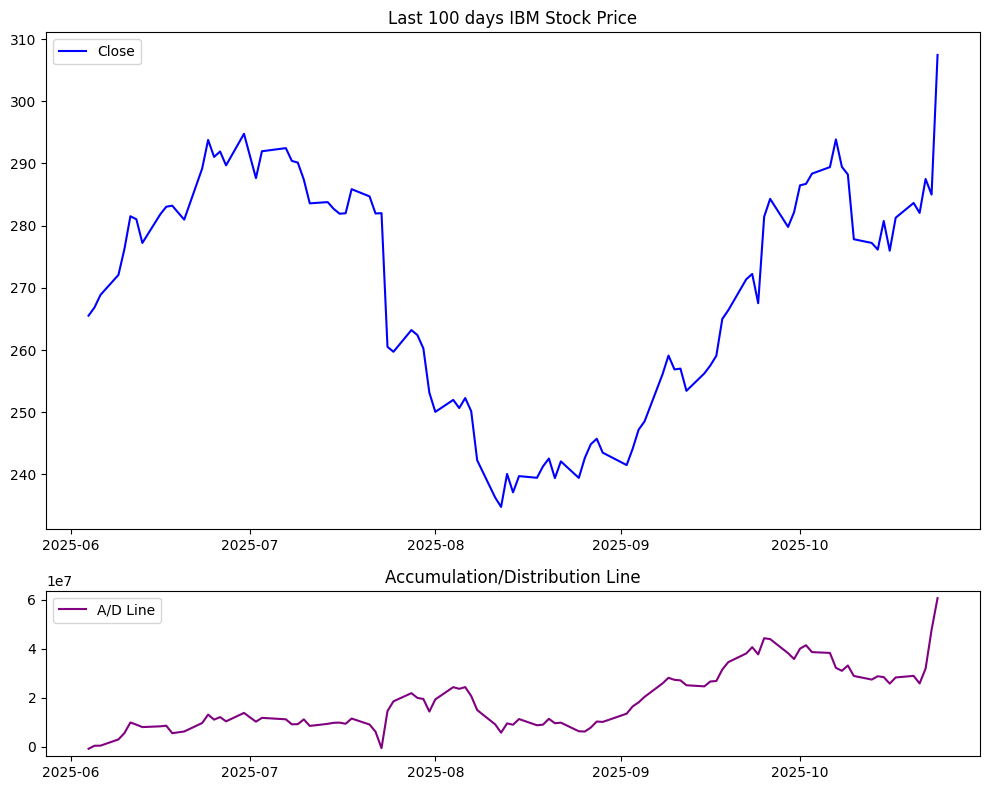

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

# Top: Price plot
axs[0].plot(df_ad.index, df_ad['val_close'], label='Close', color='blue')
axs[0].set_title(f"Last 100 days {ticker} Stock Price")
axs[0].legend()

# Bottom: A/D Line plot
axs[1].plot(df_ad.index, df_ad['ad_line'], label='A/D Line', color='purple')
axs[1].set_title('Accumulation/Distribution Line')
axs[1].legend()

plt.tight_layout()
plt.show()

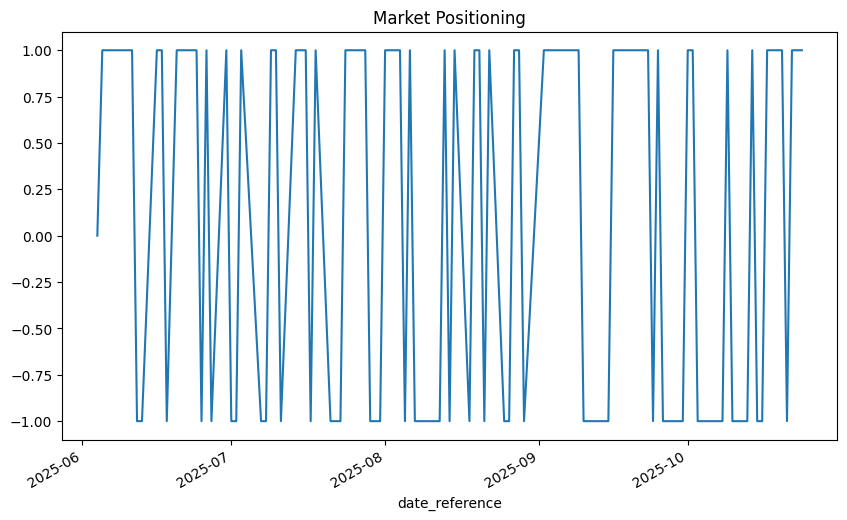

In [7]:
# Generate positions for the strategy (1 for accumulation/upward A/D, -1 for distribution/downward, 0 flat)
df_ad['ad_change'] = df_ad['ad_line'].diff()
df_ad['position'] = np.where(df_ad['ad_change'] > 0, 1, np.where(df_ad['ad_change'] < 0, -1, 0))
df_ad['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10, 6)
);

In [8]:
df_ad['returns'] = np.log(df_ad['val_close'] / df_ad['val_close'].shift(1))
df_ad['strategy'] = df_ad['position'].shift(1) * df_ad['returns']
df_ad[['returns', 'strategy']].sum().apply(np.exp)

returns     1.157954
strategy    1.219395
dtype: float64

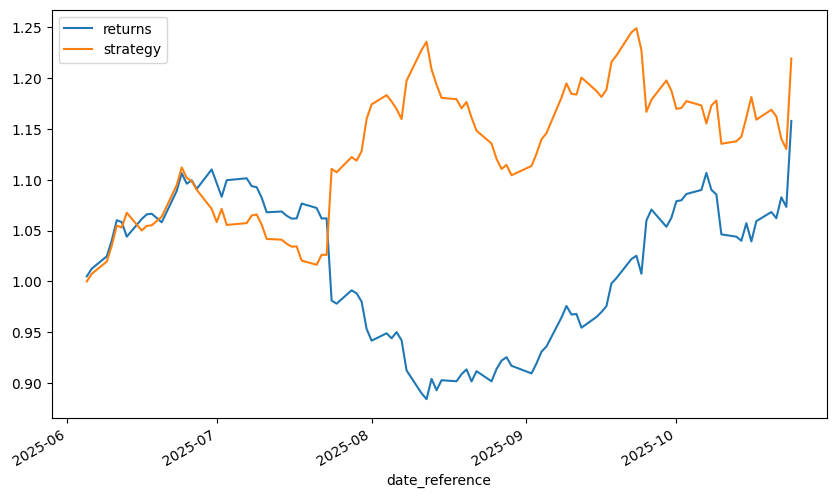

In [9]:
df_ad[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));

In [10]:
# Detect potential divergences or flattening (e.g., A/D flat while price changes)
# Flattening: where A/D change is near zero for multiple days (simple threshold)
df_ad['ad_flat'] = abs(df_ad['ad_change']) < df_ad['ad_change'].std() * 0.1  # Arbitrary small change threshold
# Divergence: Price up but A/D down, or vice versa (bearish/bullish divergence)
df_ad['price_change'] = df_ad['val_close'].diff()
df_ad['bearish_div'] = (df_ad['price_change'] > 0) & (df_ad['ad_change'] < 0)
df_ad['bullish_div'] = (df_ad['price_change'] < 0) & (df_ad['ad_change'] > 0)
events = df_ad[df_ad['bearish_div'] | df_ad['bullish_div'] | df_ad['ad_flat']]
events[['val_close', 'ad_line', 'ad_change', 'position', 'bearish_div', 'bullish_div', 'ad_flat']]

,val_close,ad_line,ad_change,position,bearish_div,bullish_div,ad_flat
date_reference,,,,,,,
2025-06-06,268.87,3.841840e+05,3.781126e+04,1,False,False,True
2025-06-16,281.83,8.283270e+06,3.122318e+05,1,False,False,True
2025-06-17,283.05,8.534355e+06,2.510851e+05,1,False,False,True
2025-06-18,283.21,5.480956e+06,-3.053400e+06,-1,True,False,False
2025-06-20,280.97,6.168776e+06,6.878203e+05,1,False,True,False
2025-07-07,292.47,1.114890e+07,-5.916723e+05,-1,True,False,False
2025-07-09,290.14,9.162667e+06,5.002204e+04,1,False,True,True
2025-07-10,287.43,1.111842e+07,1.955756e+06,1,False,True,False
2025-07-15,282.70,9.724500e+06,4.305901e+05,1,False,True,False
